In [1]:
from pyspark.sql import SparkSession, functions as F
import pandas as pd
import matplotlib.pyplot as plt

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("ADS Project 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.memory.offHeap.enabled","true") 
    .config("spark.memory.offHeap.size","10g")
    .config("spark.executor.memory", "8g")
    .config("spark.driver.memory", "8g")
    .getOrCreate())

your 131072x1 screen size is bogus. expect trouble
24/08/31 05:34:07 WARN Utils: Your hostname, LAPTOP-1A92TAQQ resolves to a loopback address: 127.0.1.1; using 172.18.166.45 instead (on interface eth0)
24/08/31 05:34:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/31 05:34:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/08/31 05:34:10 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/08/31 05:34:10 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/08/31 05:34:10 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
weather_df = spark.read.parquet('Weather/yellow_weather_data')

In [4]:
jan_df = weather_df.filter(F.col("month") == 1).drop("tpep_pickup_datetime", "tpep_dropoff_datetime").filter(F.col("payment_type")== 1)
jan_df = jan_df.dropna('any')
jan_df.count()

2259049

In [5]:
numeric_features = ["passenger_count", "trip_distance", "fare_amount", "extra", "mta_tax", 
                       "tolls_amount", "improvement_surcharge", "congestion_surcharge",
                      "airport_fee", "duration_seconds", "temperature_2m", "rain", "snow_depth",
                      "wind_speed_10m"]

categorical_features = ["hour", "day_of_week"]

features = numeric_features + categorical_features + ["PULocationID", "DOLocationID"]

In [6]:
sampled_df = jan_df.sample(withReplacement=False, fraction=0.1, seed=42)

In [7]:
jan_pdf = sampled_df.toPandas()

In [8]:
jan_pdf = jan_pdf.dropna()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Fit and transform the categorical features
encoded_array = encoder.fit_transform(jan_pdf[categorical_features])

# Convert the encoded array back to a DataFrame
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_features))

# Combine numeric features with the one-hot encoded categorical features
X_lr = pd.concat([jan_pdf[numeric_features], encoded_df], axis=1)

# Ensure that all categories (1 to 256) are considered
categories = list(range(1, 257))

# One-hot encode each column separately
pu_encoded = pd.get_dummies(jan_pdf['PULocationID'], prefix='PULocationID')
do_encoded = pd.get_dummies(jan_pdf['DOLocationID'], prefix='DOLocationID')

# Reindex to ensure all 256 categories are included
pu_encoded = pu_encoded.reindex(columns=[f'PULocationID_{i}' for i in categories], fill_value=0)
do_encoded = do_encoded.reindex(columns=[f'DOLocationID_{i}' for i in categories], fill_value=0)

# Combine the two encoded DataFrames
encoded_data = pd.concat([pu_encoded, do_encoded], axis=1)

# Combine numeric features with the one-hot encoded categorical features
X_lr = pd.concat([X_lr, encoded_data], axis=1)

In [10]:
X_lr

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,airport_fee,duration_seconds,temperature_2m,rain,snow_depth,wind_speed_10m,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,day_of_week_7,PULocationID_1,PULocationID_2,PULocationID_3,PULocationID_4,PULocationID_5,PULocationID_6,PULocationID_7,PULocationID_8,PULocationID_9,PULocationID_10,PULocationID_11,PULocationID_12,PULocationID_13,PULocationID_14,PULocationID_15,PULocationID_16,PULocationID_17,PULocationID_18,PULocationID_19,PULocationID_20,PULocationID_21,PULocationID_22,PULocationID_23,PULocationID_24,PULocationID_25,PULocationID_26,PULocationID_27,PULocationID_28,PULocationID_29,PULocationID_30,PULocationID_31,PULocationID_32,PULocationID_33,PULocationID_34,PULocationID_35,PULocationID_36,PULocationID_37,PULocationID_38,PULocationID_39,PULocationID_40,PULocationID_41,PULocationID_42,PULocationID_43,PULocationID_44,PULocationID_45,PULocationID_46,PULocationID_47,PULocationID_48,PULocationID_49,PULocationID_50,PULocationID_51,PULocationID_52,PULocationID_53,PULocationID_54,PULocationID_55,PULocationID_56,PULocationID_57,PULocationID_58,PULocationID_59,PULocationID_60,PULocationID_61,PULocationID_62,PULocationID_63,PULocationID_64,PULocationID_65,PULocationID_66,PULocationID_67,PULocationID_68,PULocationID_69,PULocationID_70,PULocationID_71,PULocationID_72,PULocationID_73,PULocationID_74,PULocationID_75,PULocationID_76,PULocationID_77,PULocationID_78,PULocationID_79,PULocationID_80,PULocationID_81,PULocationID_82,PULocationID_83,PULocationID_84,PULocationID_85,PULocationID_86,PULocationID_87,PULocationID_88,PULocationID_89,PULocationID_90,PULocationID_91,PULocationID_92,PULocationID_93,PULocationID_94,PULocationID_95,PULocationID_96,PULocationID_97,PULocationID_98,PULocationID_99,PULocationID_100,PULocationID_101,PULocationID_102,PULocationID_103,PULocationID_104,PULocationID_105,PULocationID_106,PULocationID_107,PULocationID_108,PULocationID_109,PULocationID_110,PULocationID_111,PULocationID_112,PULocationID_113,PULocationID_114,PULocationID_115,PULocationID_116,PULocationID_117,PULocationID_118,PULocationID_119,PULocationID_120,PULocationID_121,PULocationID_122,PULocationID_123,PULocationID_124,PULocationID_125,PULocationID_126,PULocationID_127,PULocationID_128,PULocationID_129,PULocationID_130,PULocationID_131,PULocationID_132,PULocationID_133,PULocationID_134,PULocationID_135,PULocationID_136,PULocationID_137,PULocationID_138,PULocationID_139,PULocationID_140,PULocationID_141,PULocationID_142,PULocationID_143,PULocationID_144,PULocationID_145,PULocationID_146,PULocationID_147,PULocationID_148,PULocationID_149,PULocationID_150,PULocationID_151,PULocationID_152,PULocationID_153,PULocationID_154,PULocationID_155,PULocationID_156,PULocationID_157,PULocationID_158,PULocationID_159,PULocationID_160,PULocationID_161,PULocationID_162,PULocationID_163,PULocationID_164,PULocationID_165,PULocationID_166,PULocationID_167,PULocationID_168,PULocationID_169,PULocationID_170,PULocationID_171,PULocationID_172,PULocationID_173,PULocationID_174,PULocationID_175,PULocationID_176,PULocationID_177,PULocationID_178,PULocationID_179,PULocationID_180,PULocationID_181,PULocationID_182,PULocationID_183,PULocationID_184,PULocationID_185,PULocationID_186,PULocationID_187,PULocationID_188,PULocationID_189,PULocationID_190,PULocationID_191,PULocationID_192,PULocationID_193,PULocationID_194,PULocationID_195,PULocationID_196,PULocationID_197,PULocationID_198,PULocationID_199,PULocationID_200,PULocationID_201,PULocationID_202,PULocationID_203,PULocationID_204,PULocationID_205,PULocationID_206,PULocationID_207,PULocationID_208,PULocationID_209,PULocationID_210,PULocationID_211,PULocationID_212,PULocationID_213,PULocationID_214,PULocationID_215,PULoca

In [11]:
y = jan_pdf['tip_amount']

In [12]:
weather_2024_df = spark.read.parquet('Weather_2024/yellow_weather_data')

jan_2024_df = weather_2024_df.filter(F.col("month") == 1).drop("tpep_pickup_datetime", "tpep_dropoff_datetime").filter(F.col("payment_type") == 1)
jan_2024_df = jan_2024_df.dropna('any')
jan_2024_df.count()

sampled_df = jan_2024_df.sample(withReplacement=False, fraction=0.1, seed=42)

jan_2024_pdf = sampled_df.toPandas()

In [13]:
jan_2024_pdf = jan_2024_pdf.dropna()

In [14]:
jan_2024_pdf.count()

month                    215066
day                      215066
hour                     215066
day_of_week              215066
passenger_count          215066
trip_distance            215066
PULocationID             215066
DOLocationID             215066
payment_type             215066
fare_amount              215066
extra                    215066
mta_tax                  215066
tip_amount               215066
tolls_amount             215066
improvement_surcharge    215066
congestion_surcharge     215066
airport_fee              215066
duration_seconds         215066
temperature_2m           215066
precipitation            215066
rain                     215066
snow_depth               215066
wind_speed_10m           215066
dtype: int64

In [15]:
# Initialize the OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Fit and transform the categorical features
encoded_array = encoder.fit_transform(jan_2024_pdf[categorical_features])

# Convert the encoded array back to a DataFrame
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_features))

# Combine numeric features with the one-hot encoded categorical features
X_test_lr = pd.concat([jan_2024_pdf[numeric_features], encoded_df], axis=1)

# Ensure that all categories (1 to 256) are considered
categories = list(range(1, 257))

# One-hot encode each column separately
pu_encoded = pd.get_dummies(jan_2024_pdf['PULocationID'], prefix='PULocationID')
do_encoded = pd.get_dummies(jan_2024_pdf['DOLocationID'], prefix='DOLocationID')

# Reindex to ensure all 256 categories are included
pu_encoded = pu_encoded.reindex(columns=[f'PULocationID_{i}' for i in categories], fill_value=0)
do_encoded = do_encoded.reindex(columns=[f'DOLocationID_{i}' for i in categories], fill_value=0)

# Combine the two encoded DataFrames
encoded_data = pd.concat([pu_encoded, do_encoded], axis=1)

# Combine numeric features with the one-hot encoded categorical features
X_test_lr = pd.concat([X_test_lr, encoded_data], axis=1)

In [16]:
X_test_lr

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,airport_fee,duration_seconds,temperature_2m,rain,snow_depth,wind_speed_10m,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,day_of_week_7,PULocationID_1,PULocationID_2,PULocationID_3,PULocationID_4,PULocationID_5,PULocationID_6,PULocationID_7,PULocationID_8,PULocationID_9,PULocationID_10,PULocationID_11,PULocationID_12,PULocationID_13,PULocationID_14,PULocationID_15,PULocationID_16,PULocationID_17,PULocationID_18,PULocationID_19,PULocationID_20,PULocationID_21,PULocationID_22,PULocationID_23,PULocationID_24,PULocationID_25,PULocationID_26,PULocationID_27,PULocationID_28,PULocationID_29,PULocationID_30,PULocationID_31,PULocationID_32,PULocationID_33,PULocationID_34,PULocationID_35,PULocationID_36,PULocationID_37,PULocationID_38,PULocationID_39,PULocationID_40,PULocationID_41,PULocationID_42,PULocationID_43,PULocationID_44,PULocationID_45,PULocationID_46,PULocationID_47,PULocationID_48,PULocationID_49,PULocationID_50,PULocationID_51,PULocationID_52,PULocationID_53,PULocationID_54,PULocationID_55,PULocationID_56,PULocationID_57,PULocationID_58,PULocationID_59,PULocationID_60,PULocationID_61,PULocationID_62,PULocationID_63,PULocationID_64,PULocationID_65,PULocationID_66,PULocationID_67,PULocationID_68,PULocationID_69,PULocationID_70,PULocationID_71,PULocationID_72,PULocationID_73,PULocationID_74,PULocationID_75,PULocationID_76,PULocationID_77,PULocationID_78,PULocationID_79,PULocationID_80,PULocationID_81,PULocationID_82,PULocationID_83,PULocationID_84,PULocationID_85,PULocationID_86,PULocationID_87,PULocationID_88,PULocationID_89,PULocationID_90,PULocationID_91,PULocationID_92,PULocationID_93,PULocationID_94,PULocationID_95,PULocationID_96,PULocationID_97,PULocationID_98,PULocationID_99,PULocationID_100,PULocationID_101,PULocationID_102,PULocationID_103,PULocationID_104,PULocationID_105,PULocationID_106,PULocationID_107,PULocationID_108,PULocationID_109,PULocationID_110,PULocationID_111,PULocationID_112,PULocationID_113,PULocationID_114,PULocationID_115,PULocationID_116,PULocationID_117,PULocationID_118,PULocationID_119,PULocationID_120,PULocationID_121,PULocationID_122,PULocationID_123,PULocationID_124,PULocationID_125,PULocationID_126,PULocationID_127,PULocationID_128,PULocationID_129,PULocationID_130,PULocationID_131,PULocationID_132,PULocationID_133,PULocationID_134,PULocationID_135,PULocationID_136,PULocationID_137,PULocationID_138,PULocationID_139,PULocationID_140,PULocationID_141,PULocationID_142,PULocationID_143,PULocationID_144,PULocationID_145,PULocationID_146,PULocationID_147,PULocationID_148,PULocationID_149,PULocationID_150,PULocationID_151,PULocationID_152,PULocationID_153,PULocationID_154,PULocationID_155,PULocationID_156,PULocationID_157,PULocationID_158,PULocationID_159,PULocationID_160,PULocationID_161,PULocationID_162,PULocationID_163,PULocationID_164,PULocationID_165,PULocationID_166,PULocationID_167,PULocationID_168,PULocationID_169,PULocationID_170,PULocationID_171,PULocationID_172,PULocationID_173,PULocationID_174,PULocationID_175,PULocationID_176,PULocationID_177,PULocationID_178,PULocationID_179,PULocationID_180,PULocationID_181,PULocationID_182,PULocationID_183,PULocationID_184,PULocationID_185,PULocationID_186,PULocationID_187,PULocationID_188,PULocationID_189,PULocationID_190,PULocationID_191,PULocationID_192,PULocationID_193,PULocationID_194,PULocationID_195,PULocationID_196,PULocationID_197,PULocationID_198,PULocationID_199,PULocationID_200,PULocationID_201,PULocationID_202,PULocationID_203,PULocationID_204,PULocationID_205,PULocationID_206,PULocationID_207,PULocationID_208,PULocationID_209,PULocationID_210,PULocationID_211,PULocationID_212,PULocationID_213,PULocationID_214,PULocationID_215,PULoca

In [17]:
y_test = jan_2024_pdf['tip_amount']

In [18]:
model = LinearRegression()
model.fit(X_lr,y)

# Make predictions on the test set
lr_y_pred = model.predict(X_test_lr)

In [19]:
lr_y_pred

array([2.66958394, 2.14238817, 3.02533614, ..., 2.85671724, 6.635002  ,
       4.0744242 ])

In [20]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, lr_y_pred)
r2 = r2_score(y_test, lr_y_pred)

print(f"Mean Squared Error: {mse}")

Mean Squared Error: 5.923527222920996


In [21]:
jan_2024_pdf['lr_predicted_tip_amount'] = lr_y_pred

In [22]:
X_rf = jan_pdf[features]

In [23]:
X_rf

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,airport_fee,duration_seconds,temperature_2m,rain,snow_depth,wind_speed_10m,hour,day_of_week,PULocationID,DOLocationID
0,1,2.51,14.9,1.0,0.5,0.0,1.0,2.5,0.0,765,8.67,0.4,0.0,11.27,0,1,48,238
1,1,4.50,20.5,3.5,0.5,0.0,1.0,2.5,0.0,889,8.67,0.4,0.0,11.27,0,1,113,255
2,2,2.30,13.5,3.5,0.5,0.0,1.0,2.5,0.0,767,8.67,0.4,0.0,11.27,0,1,43,262
3,5,2.35,23.3,1.0,0.5,0.0,1.0,2.5,0.0,1715,8.67,0.4,0.0,11.27,0,1,43,233
4,1,1.97,12.1,1.0,0.5,0.0,1.0,2.5,0.0,567,8.67,0.4,0.0,11.27,0,1,263,151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225911,1,1.58,10.7,1.0,0.5,0.0,1.0,2.5,0.0,441,2.62,0.0,0.0,10.24,23,3,142,33
225912,1,1.49,11.4,1.0,0.5,0.0,1.0,2.5,0.0,613,2.62,0.0,0.0,10.24,23,3,90,100
225913,1,0.71,5.8,1.0,0.5,0.0,1.0,2.5,0.0,157,2.62,0.0,0.0,10.24,23,3,158,68
225914,1,4.92,31.0,1.0,0.5,0.0,1.0,2.5,0.0,1931,2.62,0.0,0.0,10.24,23,3,68,249


In [24]:
X_test_rf = jan_2024_pdf[features]

In [25]:
X_test_rf

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,airport_fee,duration_seconds,temperature_2m,rain,snow_depth,wind_speed_10m,hour,day_of_week,PULocationID,DOLocationID
0,1,0.94,8.6,1.0,0.5,0.00,1.0,2.5,0.00,453,3.52,0.0,0.0,5.69,0,2,158,113
1,2,1.08,8.6,1.0,0.5,0.00,1.0,2.5,0.00,406,3.52,0.0,0.0,5.69,0,2,148,4
2,2,2.09,12.8,1.0,0.5,0.00,1.0,2.5,0.00,661,3.52,0.0,0.0,5.69,0,2,233,79
3,1,2.23,14.2,1.0,0.5,0.00,1.0,2.5,0.00,813,3.52,0.0,0.0,5.69,0,2,79,229
4,5,0.55,5.1,1.0,0.5,0.00,1.0,2.5,0.00,166,3.52,0.0,0.0,5.69,0,2,239,143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215061,1,18.02,70.0,0.0,0.5,6.94,1.0,2.5,1.75,3457,2.52,0.0,0.0,9.00,23,4,132,164
215062,1,30.91,70.0,0.0,0.5,0.00,1.0,2.5,1.75,3310,2.52,0.0,0.0,9.00,23,4,132,143
215063,1,1.60,10.7,3.5,0.5,0.00,1.0,2.5,0.00,549,2.52,0.0,0.0,9.00,23,4,234,48
215064,1,7.68,31.0,1.0,0.5,0.00,1.0,2.5,0.00,865,2.52,0.0,0.0,9.00,23,4,230,243


In [26]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Step 3: Train the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_rf, y)

# Step 4: Make Predictions
rf_y_pred = model.predict(X_test_rf)

# Evaluate the model performance
mse = mean_squared_error(y_test, rf_y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 6.313879081638892


In [27]:
jan_2024_pdf['rf_predicted_tip_amount'] = rf_y_pred

In [28]:
jan_2024_pdf

,month,day,hour,day_of_week,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,airport_fee,duration_seconds,temperature_2m,precipitation,rain,snow_depth,wind_speed_10m,lr_predicted_tip_amount,rf_predicted_tip_amount
0,1,1,0,2,1,0.94,158,113,1,8.6,1.0,0.5,2.72,0.00,1.0,2.5,0.00,453,3.52,0.0,0.0,0.0,5.69,2.669584,2.1981
1,1,1,0,2,2,1.08,148,4,1,8.6,1.0,0.5,2.72,0.00,1.0,2.5,0.00,406,3.52,0.0,0.0,0.0,5.69,2.142388,2.0048
2,1,1,0,2,2,2.09,233,79,1,12.8,1.0,0.5,3.56,0.00,1.0,2.5,0.00,661,3.52,0.0,0.0,0.0,5.69,3.025336,2.9132
3,1,1,0,2,1,2.23,79,229,1,14.2,1.0,0.5,2.00,0.00,1.0,2.5,0.00,813,3.52,0.0,0.0,0.0,5.69,3.204771,2.9592
4,1,1,0,2,5,0.55,239,143,1,5.1,1.0,0.5,1.52,0.00,1.0,2.5,0.00,166,3.52,0.0,0.0,0.0,5.69,1.956925,1.9034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215061,1,31,23,4,1,18.02,132,164,1,70.0,0.0,0.5,16.54,6.94,1.0,2.5,1.75,3457,2.52,0.0,0.0,0.0,9.00,13.970795,13.6020
215062,1,31,23,4,1,30.91,132,143,1,70.0,0.0,0.5,0.10,0.00,1.0,2.5,1.75,3310,2.52,0.0,0.0,0.0,9.00,12.692374,13.1682
215063,1,31,23,4,1,1.60,234,48,1,10.7,3.5,0.5,0.00,0.00,1.0,2.5,0.00,549,2.52,0.0,0.0,0.0,9.00,2.856717,2.7012
215064,1,31,23,4,1,7.68,230,243,1,31.0,1.0,0.5,7.20,0.00,1.0,2.5,0.00,865,2.52,0.0,0.0,0.0,9.00,6.635002,5.7598


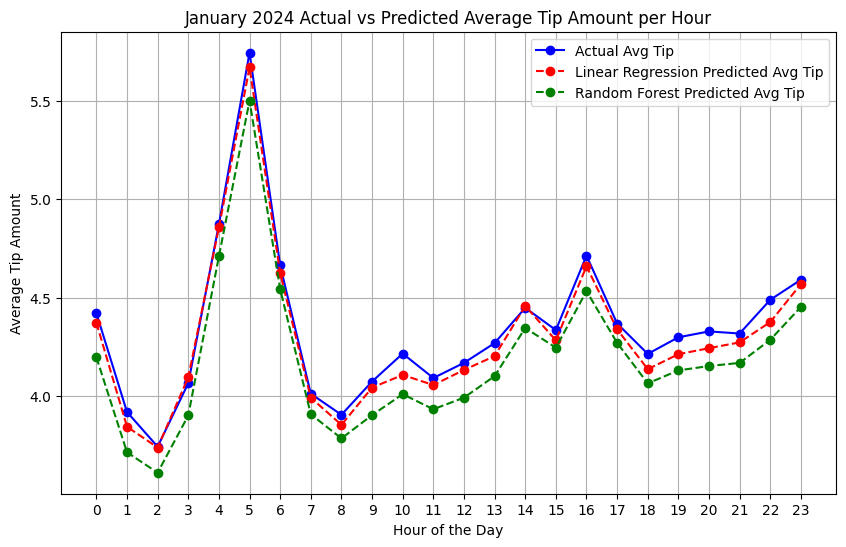

In [29]:
hourly_avg_tips = jan_2024_pdf.groupby('hour').agg({
    'tip_amount': 'mean',
    'lr_predicted_tip_amount': 'mean',
    'rf_predicted_tip_amount': 'mean'
}).reset_index()

# Step 4: Plot the line graph for both actual and predicted tips
plt.figure(figsize=(10, 6))

# Plot actual average tip amount
plt.plot(hourly_avg_tips['hour'], hourly_avg_tips['tip_amount'], marker='o', linestyle='-', color='b', label='Actual Avg Tip')

# Plot predicted average tip amount
plt.plot(hourly_avg_tips['hour'], hourly_avg_tips['lr_predicted_tip_amount'], marker='o', linestyle='--', color='r', label='Linear Regression Predicted Avg Tip')

# Plot predicted average tip amount
plt.plot(hourly_avg_tips['hour'], hourly_avg_tips['rf_predicted_tip_amount'], marker='o', linestyle='--', color='g', label='Random Forest Predicted Avg Tip')

# Adding title and labels
plt.title('January 2024 Actual vs Predicted Average Tip Amount per Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Tip Amount')
plt.xticks(range(0, 24))  # Ensure all hours are shown on the x-axis
plt.grid(True)
plt.legend()  # Show the legend to distinguish between actual and predicted

plt.show()